# Progres: TME3

Fabien Mathieu - fabien.mathieu@normalesup.org

Sébastien Tixeuil - Sebastien.Tixeuil@lip6.fr

**Note**: 
- Star exercises (indicated by *) should only be done after all other exercises have been completed. They are interesting, but optional.

# Rules

1. Cite your sources
2. One file to rule them all
3. Explain
4. Execute your code


https://github.com/balouf/progres/blob/main/rules.ipynb

# TME3 objectives

The goal of TME3 is to simulate a distributed hash table based on Chord. *Simulating* means that we won't go to the *prototype*, but only look at the mechanisms that are specific to a DHT: building routing tables, insertions, etc...

Concretely, we'll ignore all the problems related to the network implementation itself (launching independent clients in VMs, managing network connections, ...). Instead, we will run everything centrally, but with a design that mimics functions running at peer level.

**Note:** Normally, after this TME, you will have all the basic notions to make a more realistic implementation of a DHT, typically at the mini-project level.

We will work on the table example given in the course.

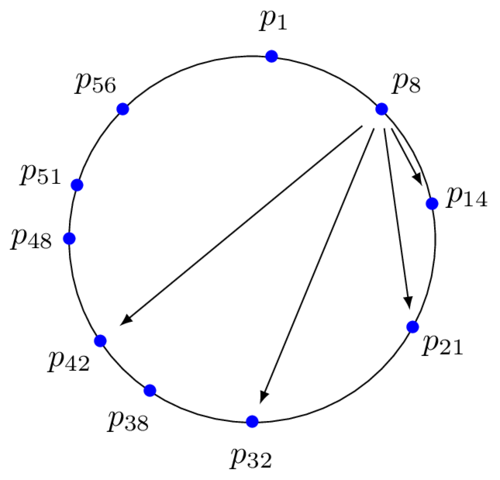

For simplicity, we identify a peer and its key. In particular, if you know the key of a peer, you can contact it. In real life, of course, you also need a real IP address or something like that. For example, $p_{38}$ is typically represented by something like `{'name': 'mymachine', 'ip': '129.199.129.1', 'port': 5365, 'hash': 38, ...)`. For the TME, we'll assume that knowing `38` is equivalent to knowing all the associated metadata.

# Exercise 1: Centralized building

To start with, we assume that we have complete knowledge and control of all the peers, and we will use all the information available to build the different routing tables.

Concretely, we assume that we have a DHT already populated with peers. The size of the key space is 64 and we have access to the peer list.

In [1]:
Nmax = 64
peers = [1, 8, 14, 21, 32, 38, 42, 48, 51, 56]

### Question 1.1

Write a function `successor` that returns the successor of a key, and a function `predecessor` that returns the predecessor of a key.

**Notes:**
- There is no DHT routing involved at this point, you just need to compute the answer with the full knowledge of the system.
- Remind to handle the modulo (the *top* of the ring).

Answer (don't forget to explain)

In [2]:
def successor(key, peers=peers):
    ...
    
def predecessor(key, peers=peers):
    ...

In [5]:
print('\n'.join(f"The successor of the key {p} is the peer {successor(p)}." for p in [30, 42, 60]))

The successor of the key 30 is the peer 32.
The successor of the key 42 is the peer 48.
The successor of the key 60 is the peer 1.


In [6]:
print('\n'.join(f"The predecessor of the key {p} is the peer {predecessor(p)}." for p in [37, 1]))

The predecessor of the key 37 is the peer 32.
The predecessor of the key 1 is the peer 56.


### Question 1.2

Write a function `make_dht` that returns a dictionary that associates to each peer its own key, its successor, its predecessor, and its finger table. Like for the previous question, you can access the list `peers`, which gives you full knowledge of the network.

Answer (don't forget to explain)

In [7]:
def make_dht(peers=peers):
    ...

# Exercise 2: Have Chord running 

You should now have a fully populated DHT:

In [10]:
dht

{1: {'key': 1, 'succ': 8, 'pred': 56, 'finger': [8, 14, 21, 38]},
 8: {'key': 8, 'succ': 14, 'pred': 1, 'finger': [14, 21, 32, 42]},
 14: {'key': 14, 'succ': 21, 'pred': 8, 'finger': [21, 32, 48]},
 21: {'key': 21, 'succ': 32, 'pred': 14, 'finger': [32, 38, 56]},
 32: {'key': 32, 'succ': 38, 'pred': 21, 'finger': [38, 42, 51, 1]},
 38: {'key': 38, 'succ': 42, 'pred': 32, 'finger': [42, 48, 56, 8]},
 42: {'key': 42, 'succ': 48, 'pred': 38, 'finger': [48, 51, 1, 14]},
 48: {'key': 48, 'succ': 51, 'pred': 42, 'finger': [51, 56, 1, 21]},
 51: {'key': 51, 'succ': 56, 'pred': 48, 'finger': [56, 1, 8, 21]},
 56: {'key': 56, 'succ': 1, 'pred': 51, 'finger': [1, 14, 32]}}

### Question 2.1

Write a function `isincharge` that tells if a peer $i$ is responsible of a key $k$. That function is supposed to be executed from the point of view of $i$, i.e. it should only use `dht[i]` (the data owned by $i$) and not the whole dictionary `dht`.

Answer (don't forget to explain)

In [11]:
def isincharge(dht_i, key):
    ...

In [13]:
i = 1; k = 56
isincharge(dht[i], k)

True

In [14]:
k = 55
isincharge(dht[i], k)

False

In [15]:
i = 38
[k for k in range(Nmax) if isincharge(dht[i], k)]

[32, 33, 34, 35, 36, 37]

### Question 2.2

Write a function `lookup(i, key, dht)` that returns a route to follow from a peer $i$ to reach the peer responsible of a given key. That function should only use:

- The information from `dht[i]`;
- Possibly a call `lookup(j, key, dht)`, where $j$ is a peer known to $i$.

Answer (don't forget to explain)

In [16]:
def lookup(i, key, dht=dht):
    ...

# Exercise 3: Decentralized building

Having a fully populated table centrally computed is not very *P2P*. We will now let the peers build their own routing tables.  Let us start from the start, with a unique peer, $1$.

In [23]:
new_dht = {1: {'key': 1, 'succ': 1, 'pred': 1, 'finger': []}}

As you can guess, routing is relatively simple for now...

In [24]:
lookup(1, 42, dht=new_dht)

[1]

**Note:** if the cell above returns a `RecursionError` (but returned the correct values in the previous exercise), it is likely that your function `isincharge` doesn't handle well the edge case where there is only one peer in the DHT. If that is the case, try to patch `isincharge` (question 2.1) so that it detects if a peer is alone in the DHT (and always returns `True` if that is the case).

### Question 3.1

Write a function `build_finger` with input a peer $i$ and a list of peers `candidates` and returns a finger table for $p$ populated from `candidates`. Remarks:

- A peer should not be in its own finger table.
- The finger table should not contain any duplicate.
- Remind that you do not necessarily include all candidates in the finger table.

Answer (don't forget to explain)

In [25]:
def build_finger(i, candidates):
    ...

In [27]:
build_finger(15, [1, 3, 60, 32, 7, 15, 45, 22, 60])

[22, 32, 60]

In [28]:
build_finger(42, [1, 56, 42])

[56, 1]

### Question 3.2

- Write a function `insert_peer(i, dht)` that works as seen in course. The function should use peer $1$ as insertion point (we assume $p_1$ is always in the DHT).
- Starting from a DHT that only contains $1$, insert all other peers from the list `peers` one by one, in any order you want.
- Is you DHT functional, i.e. does `lookup` returns correct routes?
- Compare it with the DHT built in Exercise 1. 
  - How complete is the new DHT?
  - What can you tell about the length of the routes returned in the new DHT?

Answer (don't forget to explain)

In [29]:
def insert_chord(i, dht):
    ...

...

In [31]:
from random import sample

new_dht = {1: {'key': 1, 'succ': 1, 'pred': 1, 'finger': []}}
for p in sample(peers[1:], len(peers)-1):
    insert_chord(p, new_dht)
    print(f"Insert peer {p} in DHT. Current DHT:")
    print(new_dht)

Insert peer 51 in DHT. Current DHT:
{1: {'key': 1, 'succ': 51, 'pred': 51, 'finger': [51]}, 51: {'key': 51, 'succ': 1, 'pred': 1, 'finger': [1]}}
Insert peer 32 in DHT. Current DHT:
{1: {'key': 1, 'succ': 32, 'pred': 51, 'finger': [32, 51]}, 51: {'key': 51, 'succ': 1, 'pred': 32, 'finger': [1, 32]}, 32: {'key': 32, 'succ': 51, 'pred': 1, 'finger': [51, 1]}}
Insert peer 8 in DHT. Current DHT:
{1: {'key': 1, 'succ': 8, 'pred': 51, 'finger': [8, 32, 51]}, 51: {'key': 51, 'succ': 1, 'pred': 32, 'finger': [1, 32]}, 32: {'key': 32, 'succ': 51, 'pred': 8, 'finger': [51, 1]}, 8: {'key': 8, 'succ': 32, 'pred': 1, 'finger': [32, 51]}}
Insert peer 48 in DHT. Current DHT:
{1: {'key': 1, 'succ': 8, 'pred': 51, 'finger': [8, 32, 51]}, 51: {'key': 51, 'succ': 1, 'pred': 48, 'finger': [1, 32]}, 32: {'key': 32, 'succ': 48, 'pred': 8, 'finger': [48, 51, 1]}, 8: {'key': 8, 'succ': 32, 'pred': 1, 'finger': [32, 51]}, 48: {'key': 48, 'succ': 51, 'pred': 32, 'finger': [51, 1, 32]}}
Insert peer 14 in DHT. Cu

...

In [32]:
{k: new_dht[k] for k in sorted(new_dht)}

{1: {'key': 1, 'succ': 8, 'pred': 56, 'finger': [8, 32, 51]},
 8: {'key': 8, 'succ': 14, 'pred': 1, 'finger': [14, 32, 51]},
 14: {'key': 14, 'succ': 21, 'pred': 8, 'finger': [21, 32, 51]},
 21: {'key': 21, 'succ': 32, 'pred': 14, 'finger': [32, 51, 14]},
 32: {'key': 32, 'succ': 38, 'pred': 21, 'finger': [38, 42, 51, 1]},
 38: {'key': 38, 'succ': 42, 'pred': 32, 'finger': [42, 51, 1, 32]},
 42: {'key': 42, 'succ': 48, 'pred': 38, 'finger': [48, 51, 1, 32]},
 48: {'key': 48, 'succ': 51, 'pred': 42, 'finger': [51, 1, 32]},
 51: {'key': 51, 'succ': 56, 'pred': 48, 'finger': [56, 1, 32]},
 56: {'key': 56, 'succ': 1, 'pred': 51, 'finger': [1, 32]}}

In [33]:
dht

{1: {'key': 1, 'succ': 8, 'pred': 56, 'finger': [8, 14, 21, 38]},
 8: {'key': 8, 'succ': 14, 'pred': 1, 'finger': [14, 21, 32, 42]},
 14: {'key': 14, 'succ': 21, 'pred': 8, 'finger': [21, 32, 48]},
 21: {'key': 21, 'succ': 32, 'pred': 14, 'finger': [32, 38, 56]},
 32: {'key': 32, 'succ': 38, 'pred': 21, 'finger': [38, 42, 51, 1]},
 38: {'key': 38, 'succ': 42, 'pred': 32, 'finger': [42, 48, 56, 8]},
 42: {'key': 42, 'succ': 48, 'pred': 38, 'finger': [48, 51, 1, 14]},
 48: {'key': 48, 'succ': 51, 'pred': 42, 'finger': [51, 56, 1, 21]},
 51: {'key': 51, 'succ': 56, 'pred': 48, 'finger': [56, 1, 8, 21]},
 56: {'key': 56, 'succ': 1, 'pred': 51, 'finger': [1, 14, 32]}}

### Question 3.3*

Propose solutions to have more populated finger tables.

Answer (don't forget to explain)

### Question 3.4*

Write a function `remove_chord(i, dht)` that handles the clean departure of a peer $i$. Test it by removing all the peers of `new_dht` one by one until only peer remains.

Answer (don't forget to explain)

 # Exercice 4: Using a bigger key space*

Using `Nmax=64`, the maximal size of the DHT is quite limited. In practical systems, the size of the key space is much bigger.

### Question 4.1*

Change for a larger key space (32 bits), create a new DHT with only peer $1$, then and insert peers with random keys until your DHT contains 10,000 peers.

Answer (don't forget to explain)

In [34]:
Nmax = 2**32
new_dht = {1: {'key': 1, 'next': 1, 'pred': 1, 'finger': []}}
...

Ellipsis

In [36]:
len(new_dht)

10000

### Question 4.2*

Generate 100,000 random keys and study how they are scattered among the 10000 pairs:
- What is the maximum number of keys a peer is responsible of?
- Draw a figure that shows the number of peers responsible for exactly $x$ keys (as a function of $x$)\.

Answer (don't forget to explain)

In [39]:
x[-1]

95

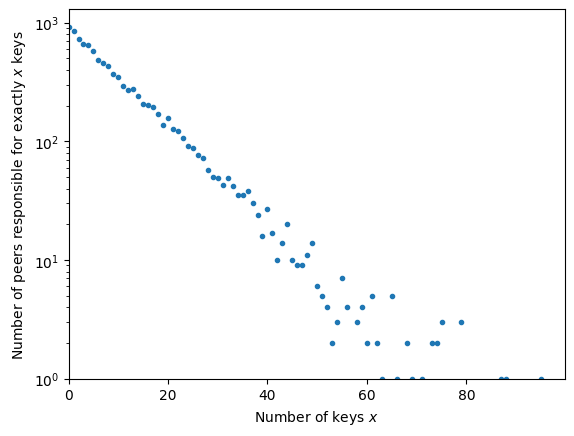

In [40]:
from matplotlib import pyplot as plt
plt.semilogy(x, n, '.')
plt.xlabel('Number of keys $x$')
plt.ylabel('Number of peers responsible for exactly $x$ keys')
plt.xlim([0, None])
plt.ylim([1, None])
plt.show()

### Question 4.3*

Draw 10000 random *lookups* (lookups computed by drawing a random existing peer and a random key).
- What is the length of the longest lookup route?
- Draw a curve that shows how many lookup have length $x$ (as a function of $x$).

Answer (don't forget to explain)

In [43]:
x[-1]

39

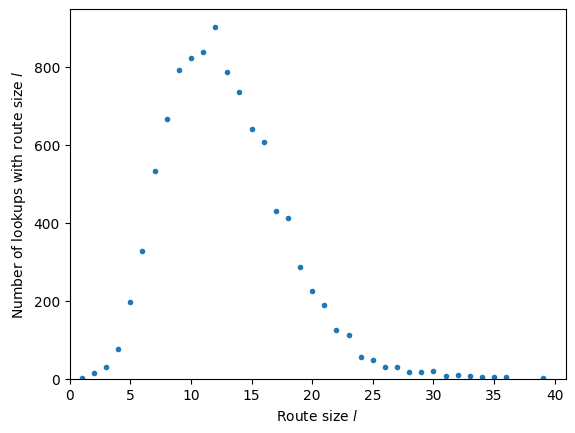

In [44]:
from matplotlib import pyplot as plt
plt.plot(x, n, '.')
plt.xlabel('Route size $l$')
plt.ylabel('Number of lookups with route size $l$')
plt.ylim([0, None])
plt.xlim([0, None])
plt.show()